In [21]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_csv('../data/ai4i2020.csv')  # Replace with your actual path if needed

# Encode 'Type' column (L, M, H → 0, 1, 2)
le = LabelEncoder()
df["Type"] = le.fit_transform(df["Type"])

# Create a unique label for each failure combination
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df["Failure_Combo"] = df[failure_columns].astype(str).agg("".join, axis=1)
df["Failure_Label"] = df["Failure_Combo"].astype("category").cat.codes

# Drop original failure columns and irrelevant ones
df.drop(failure_columns + ["UDI", "Product ID", "Machine failure", "Failure_Combo"], axis=1, inplace=True)

# features and target
X = df.drop("Failure_Label", axis=1)
y = df["Failure_Label"]

# Normalize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (Optional) Show class distribution
print("Unique classes:", y.nunique())
print(y.value_counts())

Unique classes: 12
Failure_Label
0     9652
5      106
3       80
2       78
8       42
1       18
4       11
6        6
7        3
10       2
9        1
11       1
Name: count, dtype: int64


### Model for Predicting Failure type(if any)

We'll group the data into sequences like this:

Input: Sensor data from time t-9 to t

Output: Failure label at time t+1 or t+n

This means we need time-indexed data (UDI column can help simulate order)

In [ ]:

def create_sequences(data, labels, window_size=10, forecast_horizon=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X_seq.append(data[i:i + window_size])
        y_seq.append(labels[i + window_size + forecast_horizon - 1])
    return np.array(X_seq), np.array(y_seq)

# Sorting data by UDI to simulate time
df_lstm = df.copy()
future_df = pd.read_csv('../data/ai4i2020.csv')
df_lstm["UDI"] = future_df["UDI"]  # reattaching UDI for ordering
df_lstm.sort_values("UDI", inplace=True)

# Use only scaled features
X_lstm = scaler.fit_transform(df_lstm.drop(["Failure_Label", "UDI"], axis=1))
y_lstm = df_lstm["Failure_Label"].values

# Create sequence dataset (window of 10 steps, forecast 1 step ahead)
X_seq, y_seq = create_sequences(X_lstm, y_lstm, window_size=10, forecast_horizon=1)

# Filter out classes with fewer than 2 samples
class_counts_seq = pd.Series(y_seq).value_counts()
valid_classes_seq = class_counts_seq[class_counts_seq > 1].index
X_seq_filtered = X_seq[np.isin(y_seq, valid_classes_seq)]
y_seq_filtered = y_seq[np.isin(y_seq, valid_classes_seq)]

# One-hot encode labels for multiclass classification
y_seq_cat = to_categorical(y_seq_filtered, num_classes=np.unique(y_lstm).shape[0])

# Split into train and test
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq_filtered, y_seq_cat, test_size=0.2, random_state=42, stratify=y_seq_filtered
)

# Shapes
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (7989, 10, 6)
y_train_seq shape: (7989, 12)


In [18]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train_seq.shape[1], activation='softmax')  # Multiclass output
])

# Compile the model
model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


d:\coding\Hackathon Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6731 - loss: 1.2965 - val_accuracy: 0.9637 - val_loss: 0.2281
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.2328 - val_accuracy: 0.9637 - val_loss: 0.2253
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9673 - loss: 0.1917 - val_accuracy: 0.9637 - val_loss: 0.2012
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9685 - loss: 0.1689 - val_accuracy: 0.9637 - val_loss: 0.1835
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1656 - val_accuracy: 0.9637 - val_loss: 0.1910
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9647 - loss: 0.1797 - val_accuracy: 0.9637 - val_loss: 0.1895
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.1626 - val_accuracy: 0.9637 - val_loss: 0.1849
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9690 - loss: 0.1515 - val_accuracy: 0.9637 - val_

In [19]:
# Evaluate on test data
loss, accuracy = model_lstm.evaluate(X_test_seq, y_test_seq)
print(f"LSTM Test Accuracy: {accuracy:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1964
LSTM Test Accuracy: 0.9655


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1929
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        21
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         8

    accuracy                           0.97      1998
   macro avg       0.11      0.11      0.11      1998
weighted avg       0.93      0.97      0.95      1998



d:\coding\Hackathon Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\coding\Hackathon Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\coding\Hackathon Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


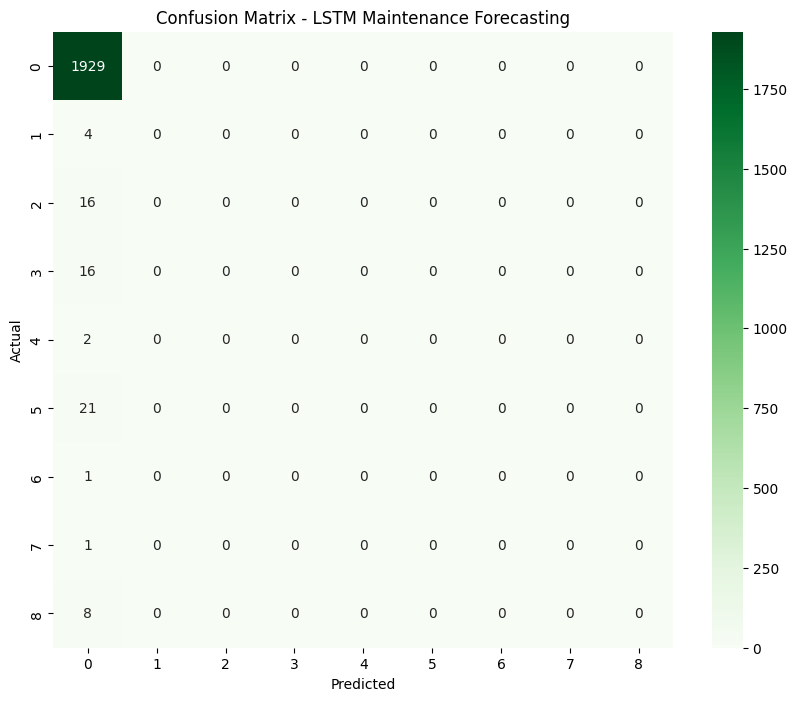

In [20]:
# Predictions
y_pred_seq_probs = model_lstm.predict(X_test_seq)
y_pred_seq = np.argmax(y_pred_seq_probs, axis=1)
y_true_seq = np.argmax(y_test_seq, axis=1)

# Report
print(classification_report(y_true_seq, y_pred_seq))

# Confusion Matrix
cm_seq = confusion_matrix(y_true_seq, y_pred_seq)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_seq, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM Maintenance Forecasting")
plt.show()


### Model to predict Maintainnace Urgency

In [ ]:

# Load dataset
df = pd.read_csv("../data/realistic_noisy_maintenance_dataset.csv")

# Label encoding for machine type
df["Type_encoded"] = df["Type"].astype("category").cat.codes

# Create classification labels
def classify_maintenance(days):
    if days <= 3:
        return 0  # High urgency
    elif days <= 7:
        return 1  # Medium urgency
    else:
        return 2  # Low urgency

df["Maintenance_Class"] = df["Days_Until_Next_Maintenance"].apply(classify_maintenance)

# features and labels
features = [
    "Type_encoded",
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]
X = df[features]
y = df["Maintenance_Class"]

# Impute to handle misssing values and scale
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# One-hot encode labels
y_encoded = to_categorical(y, num_classes=3)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Sequence generator - prepares sequential data for models like LSTMs or RNNs by generating batches of input-output pairs with time dependencies
n_input = 5
n_features = X_train.shape[1]
train_gen = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=32)
test_gen = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=32)

# LSTM classification model
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_input, n_features)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_gen, epochs=40, validation_data=test_gen, callbacks=[early_stop], verbose=1)



Epoch 1/40


d:\coding\Hackathon Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\coding\Hackathon Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9238 - loss: 0.4233 - val_accuracy: 1.0000 - val_loss: 1.4417e-04
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.8489e-05 - val_accuracy: 1.0000 - val_loss: 4.6214e-05
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0737e-05 - val_accuracy: 1.0000 - val_loss: 2.1933e-05
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5757e-05 - val_accuracy: 1.0000 - val_loss: 1.2517e-05
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.2380e-06 - val_accuracy: 1.0000 - val_loss: 7.9806e-06
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.8020e-06 - val_accuracy: 1.0000 - val_loss: 5.4618e-06
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.4445e-06 - val_accuracy: 1.0000 - val_loss: 3.9329e-06
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [26]:
# Evaluate
y_pred_probs = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(np.concatenate([y for _, y in test_gen]), axis=1)

print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



KeyboardInterrupt



In [ ]:

# Labels
class_labels = ["High (0-3)", "Medium (4-7)", "Low (8+)"]

# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Plot prediction distribution
pred_counts = pd.Series(y_pred_classes).value_counts().sort_index()
true_counts = pd.Series(y_true_classes).value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_width = 0.35
x = np.arange(len(class_labels))

plt.bar(x - bar_width/2, true_counts, width=bar_width, label="True")
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label="Predicted")
plt.xticks(x, class_labels)
plt.xlabel("Maintenance Urgency Class")
plt.ylabel("Number of Samples")
plt.title("True vs Predicted Class Distribution")
plt.legend()
plt.tight_layout()
plt.show()
